# Super-resolution using autoencoder.

The aim of this project is to find a way to generate a model trained on autoencoder by comparing image pairs of low resolution and high resolution images resulting in learning a to predict a HQ image from a LQ image.

Team 10
Name =  Tanveer Md Tanjeem
Id = 17-35663-3
Email= tanveertanjeem@gmail.com

Name: Imon, A.N.M. Ahsanul Islam 
Id : 17-35499-3
Email: imon.ahsanul.islam@gmail.com

Name: Shanin,Nafis Imtiaz
Id: 17-35525-3
Email: mdshanin2015@gmail.com

Name: Shafiq Ahmed
Id: 18-38454-2
Email: shafiqahmd3@gmail.com

## The libraries
The libraries that we mainly need includes:
- OS -The OS module in python provides functions for interacting with the operating system. OS, comes under Python's standard utility modules. This module provides a portable way of using operating system dependent functionality.
- re - A Regular Expression (RE) in a programming language is a special text string used for describing a search pattern. It is extremely useful for extracting information from text such as code, files, log, spreadsheets or even documents.
- scipy - free and open-source Python library used for scientific computing and technical computing
     - scipy.ndimage - This package contains various functions for multidimensional image processing.
     - scipy.misc - Various utilities that don’t have another home.
- skimage - It is an image processing Python package that works with numpy arrays.
     - skimage.transform.resize - Resize image to match a certain size.
     - skimage.transform.rescale - Scale image by a certain factor.
- matplotlib - Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
    - matplotlib.pyplot - is a state-based interface to matplotlib.
    
- numpy -  It is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
    - numpy.np - Numpy provides a large set of numeric datatypes that you can use to construct arrays.
- tensorflow - TensorFlow is a free and open-source software library for dataflow and differentiable programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks. 
    - tensorflow.keras.layers.input -  is used to instantiate a Keras tensor.
    - tensorflow.keras.layers.Dense - Provides a denslely connected layer.
    - tensorflow.keras.layers.Conv2D - A 2D convolution layer
    - tensorflow.keras.layers.MaxPooling2D - tensorflow.keras.layers.Conv2D operation in 2d SpatiaDropout -
    - tensorflow.keras.layers.Dropout - The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. 
    - tensorflow.keras.layers.Conv2DTranspose - Transposed convolution layer
    - tensorflow.keras.layers.Upsampling2D - Upsampling layers of 2d inputs
    - tensorflow.keras.layers.add - A layers that adds a list of inputs.
    - tensorflow.keras.models - Code for model cloning, plus model-related API entries.
        - Class Model - groups layers into an object with training and inference features.
    - tensorflow.keras.regularizer - Built-in regularizers.
        - Class L1 -  A regularizer that applies a L1 regularization penalty.


In [1]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf
print(tf.__version__)

2.1.0


# Building the Encoder

## Encoder
This is an encoder layer consisting of 4 inner layers
  - Here we take a 256x256 size of image as input.
  - In layer 1 we Do a Convolution with 64 different kind of 3x3 filters, with same padding and activation relu(Because this is popular) Ans we use Lasso as activity regularizer(We have taken a small value).
  - Layer 2 is same is alyer 1 but we do the computation on Layer 1 instead of input image
  - In the third layer we use a MaxPooling2D for a smaple based Discretization and therefore downsampling the layer 2
  - Layer 4 and 5 act just like layer 1 and 2 but computes on layer 3 and layer 4 respectively and these layers have 128 filters
  - Layer 6 acts same like layer 3 however the layer computes on layer 5
  - Layer 7 is again a 2D convolution applied on layer 6 but with 256 filters
  
  
  
Finally we put the model into a variable called encoder using the Model() function
For summary of the model we use .summary() on the model
  

In [2]:
input_img=Input(shape=(256,256,3))
l1=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(input_img)  
l2=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)
l7=Conv2D(256,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l6)
encoder=Model(input_img,l7)

In [3]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

# Building the Autoencoder

## this autoencoder
It consists of both encoder and decoder
From layer 1 to layer 7 is exactly same as the Encoder that we have built before.
(NOTE: We need encoder here so that we can share knowledge from the encoder and prevent the decoder from loosing information by not going deeper, )
The decoderr is reverse of encoder just wherever we did maxpool we need to use add them to the layer in decoder. This is done to prevent the exploding gradient in the layer.


In [4]:
input_img=Input(shape=(256,256,3))
l1=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(input_img)
l2=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l1)
l3=MaxPooling2D(padding='same')(l2)
l4=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l3)
l5=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l4)
l6=MaxPooling2D(padding='same')(l5)
l7=Conv2D(256,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l6)


In [5]:
l8= UpSampling2D()(l7)
l9=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l8)
l10=Conv2D(128,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l9)
l11=add([l5,l10])
l12=UpSampling2D()(l11)
l13=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l12)
l14=Conv2D(64,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l13)
l15=add([l14,l2])
decoded=Conv2D(3,(3,3),padding='same',activation='relu',
          activity_regularizer=regularizers.l1(10e-10))(l15)
autoencoder=Model(input_img,decoded)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_6[0][0]                   
____________________________________________________________________________________________

# Compiling the autoencoder

In [6]:
autoencoder.compile(optimizer='adadelta',loss='mean_squared_error')

# Batch training

In [7]:
def train_batches(just_load_dataset=False):
    batches = 256 
    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    ep = 4 
    images = []
    x_train_n = []
    x_train_down = []
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("/home/Desktop/Project/data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1
                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                       
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                      
                        print('Training batch', batch_nb, '(', batches, ')')
                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                   
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0
    return x_train_n2, x_train_down2

# Running the batch training code

In [8]:
x_train_n,x_train_down=train_batches(just_load_dataset=True)

/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


# Loading pretrained models

In [9]:
autoencoder.load_weights('/home/Desktop/Project/data/auto2.hdf5')

In [10]:
encoder.load_weights('/home/Desktop/Project/data/encoder.hdf5')

In [11]:
print(len(x_train_down))
print(len(x_train_n))


256
256


# Predicting the trained data

In [12]:
encoded_imgs=encoder.predict(x_train_down)

In [13]:
print(type(x_train_down))
print(x_train_down.shape)

<type 'numpy.ndarray'>
(256, 256, 256, 3)


In [14]:
encoded_imgs.shape

(256, 64, 64, 256)

# SuperREsolution pictures from LQ images

In [15]:
sr1=np.clip(autoencoder.predict(x_train_down),0.0,1.0)

# Generating Random value

In [16]:
image_index=np.random.randint(0,256)

# Plotting diagram
|LQ image|  |Bicubic image| |Encoded image| |Our image| |Original Image|

Starting from left to right in the pictures below, The lq image is of low resolution
The second pricture is produced by using bicubic interpolation
The third image is the encoded image
The fourth image is the image we have created using autoencoder
The fifth image is the Original Image

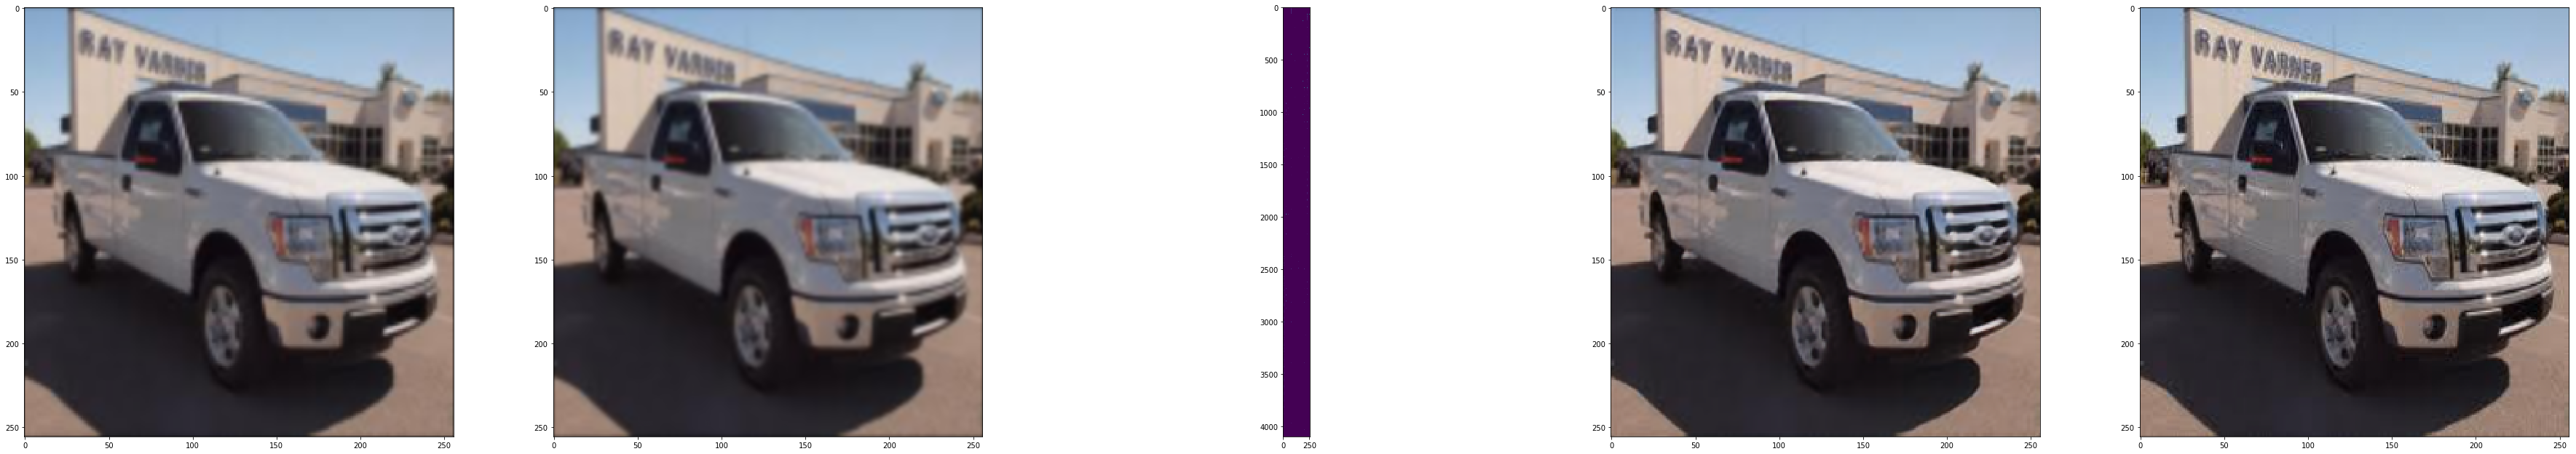

In [17]:
plt.figure(figsize=(128,128))
i=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index])
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_down[image_index],interpolation='bicubic')
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(encoded_imgs[image_index].reshape(64*64,256))
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(sr1[image_index])
i+=1
ax = plt.subplot(10,10,i)
plt.imshow(x_train_n[image_index])
plt.show()


# Comparison 

After comparing the euclidian distance of the 'nearest' 'bilinear' and 'bicubic' interpolation and the LQ image from the original image and comparing it with our method we found that our methed clearly is not better than these.
However we have successfully improved out image resolution. 

In [18]:
def euclid_dis(org_img, test_img):
    return np.sum(abs(org_img-test_img))

lq_img = euclid_dis(x_train_n[image_index],x_train_down[image_index])
nearest_img  = misc.imresize(x_train_down[image_index],(256,256), interp='nearest',mode=None)
nearest_img = euclid_dis(x_train_n[image_index],nearest_img)

bilinear_img  = misc.imresize(x_train_down[image_index],(256,256), interp='bilinear',mode=None)
bilinear_img = euclid_dis(x_train_n[image_index],bilinear_img)


bicubic_img  = misc.imresize(x_train_down[image_index],(256,256), interp='bicubic',mode=None)
bicubic_img = euclid_dis(x_train_n[image_index],bicubic_img)


sup_img = euclid_dis(x_train_n[image_index],sr1[image_index])

print('lq_img',lq_img)
print('nearest_img', nearest_img) 
print('\nbilinear_img',bilinear_img)
print('bicubic_img', bicubic_img)
print('nsup image: ',sup_img)


#plt.figure()
#langs = ['lq_img', 'nearest_img','bilinear_img','bicubic_img','sup_img']
#distance = [lq_img, nearest_img,bilinear_img, bicubic_img ,sup_img]
#plt.bar(langs,distance)
#plt.show()

('lq_img', 3848.291453888356)
('nearest_img', 21874853.06216745)
('\nbilinear_img', 21874853.06216745)
('bicubic_img', 21874853.06216745)
('nsup image: ', 2736.962584663741)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':


# Upscaled Output of image collected from image result

<type 'numpy.ndarray'>
(256, 256, 3)


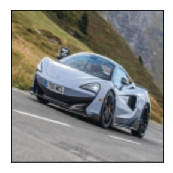

(1, 256, 256, 3)


In [19]:
new_pic = plt.imread('/home/Desktop/Project/data/unnamed.jpg')


print(type(new_pic))
print(new_pic.shape)
new_pic = rescale(rescale(new_pic, 0.5), 2.0)

#lq = np.append(lq,new_pic)
plt.subplot(1,2,1)
plt.imshow(new_pic)
plt.xticks([])
plt.yticks([])

plt.show()


lq = np.array([new_pic])
print(lq.shape)

In [20]:
encoded_imgs=encoder.predict(lq)

In [21]:
sr1=np.clip(autoencoder.predict(lq),0.0,1.0)

In [22]:
plt.figure(figsize=(256,256))

plt.subplot(1,2,1)
plt.imshow(new_pic)
plt.xticks([])
plt.yticks([])

plt.xlabel('low quality Image')

plt.subplot(1,2,2)

#plt.imshow(encoded_imgs[0].reshape(64*64,256))
plt.imshow(sr1[0])
#print(sr1)
plt.xticks([])
plt.yticks([])
plt.xlabel('superesolution Image')
plt.show()


The LQ and Improved image can be seen above

In [23]:
orginal_image = new_pic 
New_Image = sr1[0]
Euclidean_dis = np.sum(abs(orginal_image-New_Image))
print(Euclidean_dis)

3496.4757290204766


# The discussion
After going through a lot of discussions

This project is done in oder to produce a video processing program that improve video quality frame by fram. In case of video processing we actually have more images as information to work with so therefore there is chance of improving the video quality just by collecting information from a frame before and a frame after the main image.
There are a lot more research needed in case of choise of optimisation and loss choice because that also will improve the quality of this method as well.